## 케라스 자동회귀로 생성하는 방법
- Autoregressive Regression
- 애국가 데이터를 이용한 생성
- Many-to-One 모델

In [1]:
import tensorflow as tf
tf.__version__

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import numpy as np

# 애국가 예제 텍스트
text = """
동해 물과 백두산이 마르고 닳도록 하느님이 보우하사 우리나라 만세
무궁화 삼천리 화려강산 대한 사람 대한으로 길이 보전하세
남산 위에 저 소나무 철갑을 두른 듯 바람 서리 불변함은 우리 기상일세
무궁화 삼천리 화려강산 대한 사람 대한으로 길이 보전하세
"""

In [2]:
# Tokenizer 적용
tokenizer = Tokenizer()
#print('\ntokenizer:',tokenizer)

tokenizer.fit_on_texts([text])
token_list = tokenizer.texts_to_sequences([text])[0]
print('\ntoken_list:',token_list)

word_index = tokenizer.word_index
#print('\nword_index:',word_index)

vocab_size = len(word_index) + 1
print("\ntotal words:", vocab_size)



token_list: [9, 10, 11, 12, 13, 14, 15, 16, 17, 1, 2, 3, 4, 5, 6, 7, 8, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 1, 2, 3, 4, 5, 6, 7, 8]

total words: 30


In [3]:
embedding_dim = 8

input_token = Input(shape=(1,))
first_5_words = text.strip().split()[:5]
first_5_tokens = token_list[:5]
output_vector = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_token)
embedding_model = Model(inputs=input_token, outputs=output_vector)

print("\n단어(토큰)   \t→ 임베딩 벡터:")
for word, token in zip(first_5_words, first_5_tokens):
    token_array = np.array([[token]])
    embedding_vector = embedding_model.predict(token_array, verbose=0)[0][0]
    print(f"{word}({token}) \t→ {np.round(embedding_vector, 3)}")



단어(토큰)   	→ 임베딩 벡터:
동해(9) 	→ [-0.04  -0.029 -0.033  0.034  0.025  0.004 -0.018 -0.016]
물과(10) 	→ [ 0.019 -0.044  0.032  0.019 -0.007 -0.029 -0.009 -0.049]
백두산이(11) 	→ [-0.007  0.003  0.037  0.026 -0.028 -0.049  0.006  0.003]
마르고(12) 	→ [ 0.05   0.011  0.019  0.014  0.049  0.034 -0.035  0.006]
닳도록(13) 	→ [-0.033 -0.041  0.002  0.029 -0.032  0.039 -0.008 -0.017]


In [4]:
# 하이퍼파라미터 정의
embedding_dim = 32
dnn_units = 32
hidden_units = 64
max_len= 6

In [5]:
# 데이터 생성. windows=max_len
input_sequences = []
for i in range(max_len, len(token_list)):
    input_sequences.append(token_list[i-max_len:i+1])

input_sequences = np.array(input_sequences)
X = input_sequences[:, :-1]
y = to_categorical(input_sequences[:, -1], num_classes=vocab_size)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                    test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(hidden_units),
    Dense(dnn_units, activation='relu'),
    Dense(vocab_size, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=200,verbose=0)


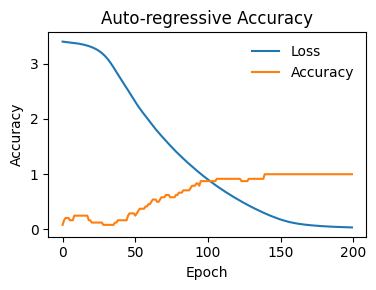

In [6]:
import matplotlib.pyplot as plt

# ▶ 학습 이력 시각화 함수
def plot_history(history, title="Model"):
    plt.figure(figsize=(4, 3))

    # Loss plot
    #plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(frameon=False)

    # Accuracy plot
   # plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()

plot_history(history, title="Auto-regressive")

In [7]:
# 테스트 정확도 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.6f}")
print(f"Test loss: {loss:.6f}")

Test Accuracy: 0.285714
Test loss: 9.730284


In [8]:
def generate_auto(seed_text, n):
    for _ in range(n):
        token_seq = tokenizer.texts_to_sequences([seed_text])[0]
        token_seq = pad_sequences([token_seq], maxlen=max_len, padding='pre')
        pred = model.predict(token_seq, verbose=0)
        next_index = np.argmax(pred)
        next_word = tokenizer.index_word[next_index]
        seed_text += ' ' + next_word
    return seed_text


In [9]:
seed = "동해 물과 백두산이 마르고"

print("Auto-regressive (1단어씩 반복 생성):")
print(generate_auto(seed, n=4))

Auto-regressive (1단어씩 반복 생성):
동해 물과 백두산이 마르고 두른 보우하사 보우하사 우리나라


In [10]:
print(generate_auto(seed, n=3))

동해 물과 백두산이 마르고 두른 보우하사 보우하사


In [11]:
print(generate_auto(seed, n=2))

동해 물과 백두산이 마르고 두른 보우하사
